# Usage of taxi services

In [2]:
import os
import logging
import json
import calendar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from datetime import datetime, time

In [3]:
class FileExtraction:
    def __init__(self, landing_path, raw_path):
        self._landing_path = landing_path
        self._raw_path = raw_path

    @property
    def landing_path(self):
        return self._landing_path

    @landing_path.setter
    def landing_path(self, path):
        self._landing_path = self.validate_directory(path)

    @property
    def raw_path(self):
        return self._raw_path

    @raw_path.setter
    def raw_path(self, path):
        self._raw_path = self.validate_directory(path)

    @staticmethod
    def validate_directory(path):
        if os.path.isdir(path):
            return path
        else:
            logging.error("Please use a valid file path.")

    def load_compressed_file(self):
        files = [file for file in os.listdir(self._landing_path)
                 if os.path.isfile(os.path.join(self._landing_path, file))]

        for file in files:
            with ZipFile(os.path.join(self._landing_path, file)) as zip_file:
                for zip_ in zip_file.namelist():
                    if zip_.endswith('.json') and "__MACOSX" not in zip_:
                        date_now = datetime.now().strftime("%m%d%Y")
                        zip_file.extract(zip_, self._raw_path)

                        os.rename(f"{self._raw_path}{zip_}", f"{self._raw_path}{date_now}_{zip_}")


In [4]:
f = FileExtraction(raw_path="../src/data/raw_file/", landing_path="../src/data/landing/")
## tratar arquivo ja existente no diretorio
f.load_compressed_file()

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: '../src/data/raw_file/taxi.json' -> '../src/data/raw_file/11132022_taxi.json'

In [5]:
def read_json_data(path):
    with open(path, 'r') as file:
        return json.loads(file.read())

In [6]:
taxi_path = "../src/data/raw_file/11132022_taxi.json"

taxi_data = read_json_data(taxi_path)

In [176]:
df_taxi = pd.json_normalize(taxi_data)

### Check data information

In [177]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23867 entries, 0 to 23866
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amount.value                23867 non-null  int64  
 1   amount.precision            23867 non-null  int64  
 2   amount.currency             23867 non-null  object 
 3   transaction_info.number     12019 non-null  float64
 4   transaction_info.machine    0 non-null      object 
 5   transaction_info.timestamp  12019 non-null  float64
 6   transaction_info.country    10352 non-null  object 
 7   transaction_info.currency   10352 non-null  object 
 8   transaction_info.partner    0 non-null      object 
dtypes: float64(2), int64(2), object(5)
memory usage: 1.6+ MB


In [178]:
# check the number of records before processing
df_before = df_taxi.shape

print(df_before)

(23867, 9)


In [179]:
df_taxi.head()

,amount.value,amount.precision,amount.currency,transaction_info.number,transaction_info.machine,transaction_info.timestamp,transaction_info.country,transaction_info.currency,transaction_info.partner
0,-279000,5,EUR,NaN,None,NaN,None,None,None
1,-1000000,5,EUR,NaN,None,NaN,None,None,None
2,-945000,5,EUR,NaN,None,NaN,None,None,None
3,-1100000,5,EUR,1.0,None,1.621374e+12,AT,EUR,None
4,-556000,5,EUR,NaN,None,NaN,None,None,None


### Rename name columns - Replace "." to "_"

In [180]:
df_taxi.columns = df_taxi.columns.str.replace('.', '_', regex = True)

In [181]:
# Check the results
df_taxi.columns

Index(['amount_value', 'amount_precision', 'amount_currency',
       'transaction_info_number', 'transaction_info_machine',
       'transaction_info_timestamp', 'transaction_info_country',
       'transaction_info_currency', 'transaction_info_partner'],
      dtype='object')

### Check number of NaN values in the dataset

In [182]:
df_taxi.isna().sum()

amount_value                      0
amount_precision                  0
amount_currency                   0
transaction_info_number       11848
transaction_info_machine      23867
transaction_info_timestamp    11848
transaction_info_country      13515
transaction_info_currency     13515
transaction_info_partner      23867
dtype: int64

### Replacing NaN values

- As described, the money amount has the precision set to 5 digits. For the exploratory analysis, the script will replace all NaN to 0 in columns with number type and replace NaN to "" to columns with string type. 

In [183]:
# check if excists any 0 in the dataset as a representative information
df_taxi.isin([0]).sum()

amount_value                  0
amount_precision              0
amount_currency               0
transaction_info_number       0
transaction_info_machine      0
transaction_info_timestamp    0
transaction_info_country      0
transaction_info_currency     0
transaction_info_partner      0
dtype: int64

In [184]:
float64 = df_taxi.select_dtypes(include=['float64']).columns
stringObject = df_taxi.select_dtypes(include=['object']).columns

In [185]:
df_taxi.loc[:, float64] = df_taxi.loc[:, float64].apply(lambda value: value.fillna(0))
df_taxi.loc[:, stringObject] = df_taxi.loc[:, stringObject].apply(lambda value: value.fillna(""))

In [186]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner
0,-279000,5,EUR,0.0,,0.000000e+00,,,
1,-1000000,5,EUR,0.0,,0.000000e+00,,,
2,-945000,5,EUR,0.0,,0.000000e+00,,,
3,-1100000,5,EUR,1.0,,1.621374e+12,AT,EUR,
4,-556000,5,EUR,0.0,,0.000000e+00,,,


In [187]:
df_taxi["transaction_info_timestamp"] =  df_taxi["transaction_info_timestamp"].apply(lambda value: 
                                                                                     pd.to_datetime(value, unit='ms', errors='coerce')
                                                                                    if value != 0 else None)

In [188]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner
0,-279000,5,EUR,0.0,,NaT,,,
1,-1000000,5,EUR,0.0,,NaT,,,
2,-945000,5,EUR,0.0,,NaT,,,
3,-1100000,5,EUR,1.0,,2021-05-18 21:34:00,AT,EUR,
4,-556000,5,EUR,0.0,,NaT,,,


In [189]:
df_taxi["amount_value"] = df_taxi["amount_value"].apply(lambda amount: float(amount))

In [190]:
df_taxi["amount_value"] = df_taxi["amount_value"]*np.float_power(10, -df_taxi["amount_precision"])


In [191]:
df_taxi.dropna(inplace= True)

In [192]:
df_taxi["day_of_the_week"] = df_taxi["transaction_info_timestamp"].apply(lambda date: calendar.day_name[date.weekday()])

In [193]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner,day_of_the_week
3,-11.0,5,EUR,1.0,,2021-05-18 21:34:00,AT,EUR,,Tuesday
5,-9.1,5,EUR,3.0,,2021-05-18 15:36:00,AT,EUR,,Tuesday
6,-14.0,5,EUR,2.0,,2021-05-18 05:55:00,AT,EUR,,Tuesday
9,-19.0,5,EUR,3.0,,2021-05-18 04:49:00,AT,EUR,,Tuesday
10,-22.0,5,EUR,1.0,,2021-05-18 05:22:00,AT,EUR,,Tuesday


## Exploratory analysis

In [194]:
# check for any positive values
(df_taxi["amount_value"] > 0).values.any()

False

In [195]:
# for better analysis, transform all negative to positive number

In [196]:
df_taxi["amount_value"] = df_taxi["amount_value"]*(-1)

In [197]:
df_taxi["amount_value"].head()

3     11.0
5      9.1
6     14.0
9     19.0
10    22.0
Name: amount_value, dtype: float64

In [198]:
amount_per_hour_per_day = df_taxi.groupby([df_taxi['transaction_info_timestamp'].dt.hour,
                                          df_taxi['day_of_the_week']]
                                         )['amount_value'].sum().unstack(fill_value=0)

In [199]:
amount_per_hour_per_day.head()

day_of_the_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
transaction_info_timestamp,,,,,,,
0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,975.91,810.70,633.70,734.84,742.33,809.00,873.12
5,1760.40,1139.16,734.83,367.32,1528.70,1263.70,1528.25
6,2111.20,1197.80,908.00,769.40,3155.02,2076.20,2013.81
7,1955.60,1451.50,951.90,788.23,2115.59,1849.91,1968.95
8,1855.09,1089.80,991.33,1009.02,1582.12,1646.78,1164.80


In [200]:
amount_per_hour_per_day.index.names = ['Hour']

In [201]:
amount_per_hour_per_day.columns.names = ["Index"]

In [202]:
amount_per_hour_per_day.head()

Index,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Hour,,,,,,,
0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,975.91,810.70,633.70,734.84,742.33,809.00,873.12


In [203]:
amount_per_hour_per_day.reset_index(level = ["Hour"], inplace = True)

In [204]:
amount_per_hour_per_day.head()

Index,Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,4,975.91,810.70,633.70,734.84,742.33,809.00,873.12


In [205]:
fat_hour = pd.DataFrame(amount_per_hour_per_day["Hour"].apply(lambda hour: time(hour).strftime("%I:00 %p")))

In [206]:
fat_hour.head()

,Hour
0,12:00 AM
1,01:00 AM
2,02:00 AM
3,03:00 AM
4,04:00 AM


In [207]:
amount_per_hour_per_day.drop("Hour", axis = 1, inplace = True)

In [208]:
amount_per_hour_per_day.head()

Index,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,975.91,810.70,633.70,734.84,742.33,809.00,873.12


In [209]:
amount_per_hour_per_day = amount_per_hour_per_day[["Monday","Tuesday","Wednesday","Thursday", "Friday", "Saturday", "Sunday"]]

In [210]:
amount_per_hour_per_day.head()

Index,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,672.36,391.30,208.40,541.30,586.80,3424.87,3021.07
1,642.89,272.90,263.55,485.28,563.71,2237.64,2137.07
2,282.50,243.69,181.80,293.20,394.98,1398.27,1538.70
3,390.90,436.60,509.00,859.40,746.69,811.40,702.86
4,810.70,809.00,873.12,742.33,975.91,633.70,734.84


### Results

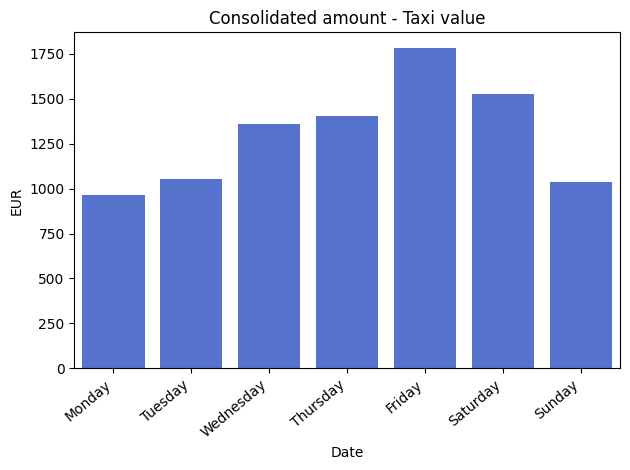

In [211]:
daily_plot = sns.barplot(amount_per_hour_per_day, errorbar = None, color = "royalblue")

daily_plot.set_title("Consolidated amount - Taxi value")
daily_plot.set_xlabel("Date")
daily_plot.set_ylabel("EUR")

daily_plot.set_xticklabels(daily_plot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [212]:
# mediana do mes

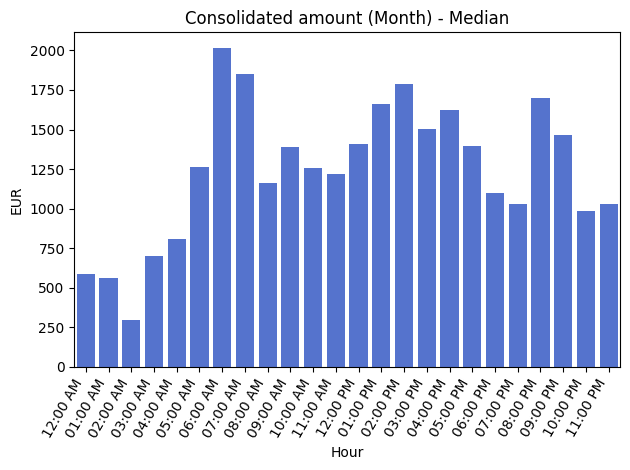

In [213]:
hour_plot = sns.barplot(y = amount_per_hour_per_day.median(axis = 1), x = fat_hour.Hour, errorbar = None, color = "royalblue")

hour_plot.set_title("Consolidated amount (Month) - Median")
hour_plot.set_xlabel("Hour")
hour_plot.set_ylabel("EUR")

hour_plot.set_xticklabels(hour_plot.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

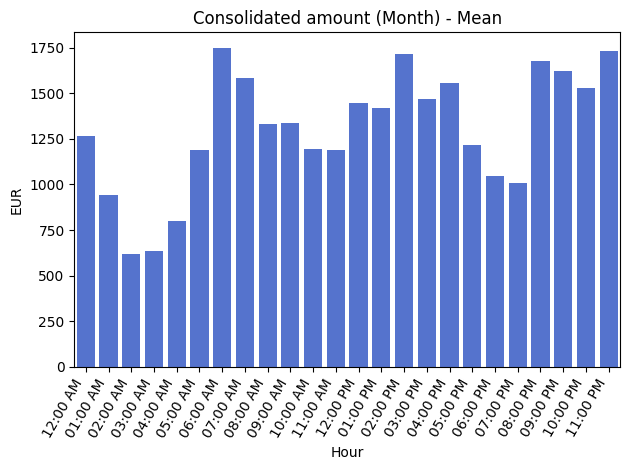

In [170]:
hour_plot = sns.barplot(y = amount_per_hour_per_day.mean(axis = 1), x = fat_hour.Hour, errorbar = None, color = "royalblue")

hour_plot.set_title("Consolidated amount (Month) - Mean")
hour_plot.set_xlabel("Hour")
hour_plot.set_ylabel("EUR")

hour_plot.set_xticklabels(hour_plot.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

In [218]:
amount_per_hour_per_day.head()

Index,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,672.36,391.30,208.40,541.30,586.80,3424.87,3021.07
1,642.89,272.90,263.55,485.28,563.71,2237.64,2137.07
2,282.50,243.69,181.80,293.20,394.98,1398.27,1538.70
3,390.90,436.60,509.00,859.40,746.69,811.40,702.86
4,810.70,809.00,873.12,742.33,975.91,633.70,734.84


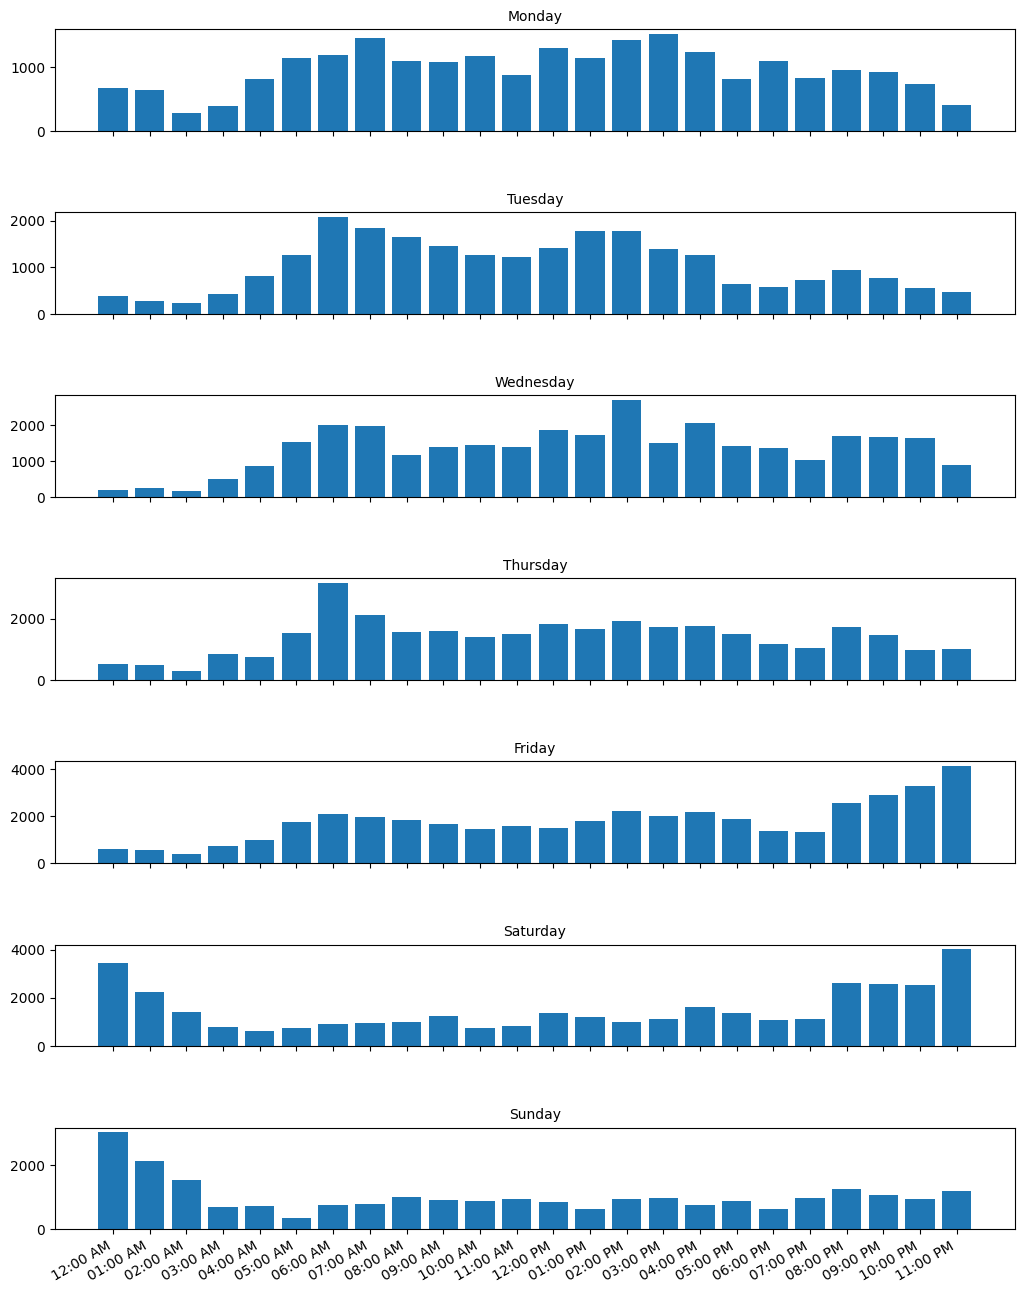

In [312]:
figure, axis = plt.subplots(7, 1, figsize=(12, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.2,
                    wspace=0.8,
                    hspace=0.8)
for index, day in enumerate(amount_per_hour_per_day):
    axis[index].bar(fat_hour.Hour, amount_per_hour_per_day[day])
    axis[index].set_title(f"{day}", fontsize=10)

figure.autofmt_xdate()
